In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
words = open('names.txt','r').read().splitlines()

In [107]:
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [4]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [6]:
C = torch.randn((27, 2))

In [46]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [47]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [16]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[ 0.8071,  0.4461, -0.7762,  ..., -0.5304,  0.4093, -0.7249],
        [ 0.8174, -0.6750, -0.4445,  ..., -0.1072,  0.5450, -0.5550],
        [ 0.9819, -0.9852, -0.8367,  ...,  0.7700,  0.9983, -0.9134],
        ...,
        [-0.5036,  0.9857,  0.4783,  ..., -0.6246, -1.0000, -0.7358],
        [ 0.4804, -0.9808,  0.9974,  ..., -1.0000, -0.8614,  1.0000],
        [-0.4223,  0.8503, -0.8132,  ..., -0.7649,  0.9977, -0.8028]])

In [17]:
h.shape

torch.Size([32, 100])

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ W2 + b2

In [20]:
logits.shape

torch.Size([32, 27])

In [21]:
counts = logits.exp()

In [22]:
prob = counts / counts.sum(1, keepdims=True)

In [23]:
prob.shape

torch.Size([32, 27])

In [25]:
loss = -prob[torch.arange(32), Y].log().mean()

In [26]:
loss

tensor(16.0529)

In [27]:
#--------------------made cleaner---------------------------

In [151]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [152]:
Xtr.shape, Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [154]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [155]:
sum(p.nelement() for p in parameters) # total number of parameters

17697

In [156]:
for p in parameters:
    p.requires_grad = True

In [157]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [158]:
lri = []
lossi = []
stepi = []

In [171]:
for i in range(50000):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    # lr = 0.1 if i < 20000 else 0.01
    lr = 0.001
    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.1328253746032715


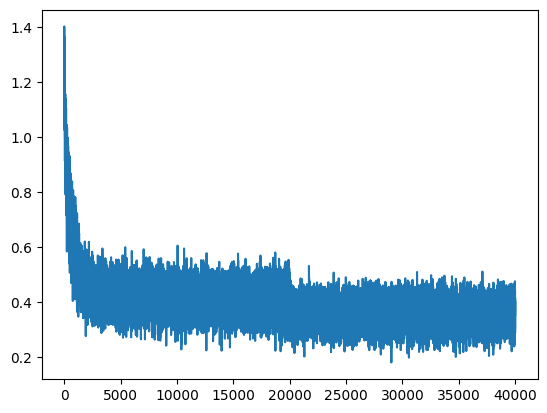

In [118]:
plt.plot(stepi, lossi)

In [172]:
#model loss pn dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1814, grad_fn=<NllLossBackward0>)

In [173]:
#model loss pn test set
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss
# dev loss and test loss roughly the same. underfitting the model. more performace by increasing the number of parameters

tensor(2.1826, grad_fn=<NllLossBackward0>)

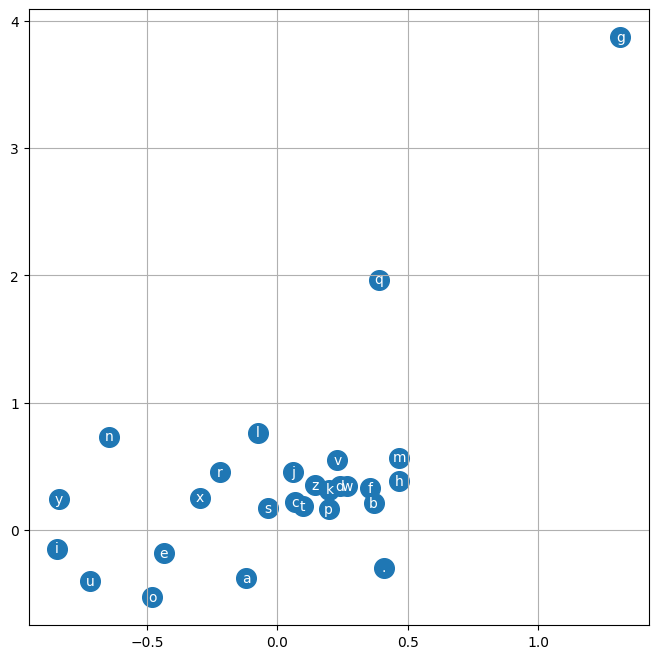

In [70]:
# visualize the embeddings for 2 dimensional model
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [174]:
#sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

moha.
mayah.
see.
med.
ryla.
reversiendrari.
adered.
elin.
shi.
jenreden.
esmanar.
kayzion.
kamin.
shuberg.
hiriel.
kindreelynn.
novana.
uzmenne.
ryyah.
faehsykaesh.
